In [1]:
import os
import kagglehub
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# Download dataset from KaggleHub
dataset_root = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")
train_dir = os.path.join(dataset_root, "Training")
test_dir = os.path.join(dataset_root, "Testing")

In [4]:
# Transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

In [5]:
# Load datasets
trainval_dataset = datasets.ImageFolder(train_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)
class_names = trainval_dataset.classes

In [6]:
# Split train into train/val
val_size = int(0.15 * len(trainval_dataset))
train_size = len(trainval_dataset) - val_size
train_dataset, val_dataset = random_split(trainval_dataset, [train_size, val_size])

In [7]:
# Data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, name, patience=5):
    best_acc = 0.0
    best_loss = float('inf')
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    early_stop_counter = 0

    for epoch in range(num_epochs):
        # ---------- Training ----------
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += (preds == labels).sum().item()
            total_train += labels.size(0)

        train_loss = running_loss / len(train_loader)
        train_acc = correct_train / total_train

        # ---------- Validation ----------
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, preds = torch.max(outputs, 1)
                correct_val += (preds == labels).sum().item()
                total_val += labels.size(0)

        val_loss /= len(val_loader)
        val_acc = correct_val / total_val

        # ---------- Logging ----------
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

        # ---------- Save best model ----------
        if val_loss < best_loss:
            best_loss = val_loss
            best_acc = val_acc
            torch.save(model.state_dict(), f"best_brain_tumor_{name}.pth")
            early_stop_counter = 0  # reset if improvement
        else:
            early_stop_counter += 1
            print(f"No improvement in validation loss for {early_stop_counter} epoch(s).")

        # ---------- Early stopping ----------
        if early_stop_counter >= patience:
            print("Early stopping triggered.")
            break

    return history


In [9]:
# Testing function
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    acc = correct / total
    print(f"Test Accuracy: {acc:.4f}")


In [10]:
def visualize_predictions(model, loader, num_images=6):
    model.eval()
    images_shown = 0
    fig = plt.figure(figsize=(12, 6))

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            for j in range(images.size(0)):
                if images_shown == num_images:
                    plt.tight_layout()
                    return

                ax = fig.add_subplot(2, num_images//2, images_shown + 1)
                img = images[j].cpu().permute(1, 2, 0).numpy()
                img = (img * 0.5 + 0.5).clip(0, 1)  # Unnormalize

                ax.imshow(img)
                true_label = class_names[labels[j]]
                pred_label = class_names[preds[j]]
                ax.set_title(f"True: {true_label}\nPred: {pred_label}", fontsize=10)
                ax.axis('off')

                images_shown += 1

    plt.tight_layout()
    plt.show()

In [11]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
def evaluate_model(model, loader, class_names, title="Confusion Matrix"):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Classification report
    print(classification_report(all_labels, all_preds, target_names=class_names))

    # Confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(title)
    plt.show()


In [12]:
# Load pretrained ResNet50
model2= models.resnet50(pretrained=True)
for param in model2.parameters():
    param.requires_grad = False

# Modify classifier
num_ftrs = model2.fc.in_features
model2.fc = nn.Sequential(
    nn.Linear(num_ftrs, 512),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(512, 4)
)
model2 = model2.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 166MB/s]


In [13]:
# First phase training
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model2.fc.parameters(), lr=0.001)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='resnet50')

Epoch [1/60] Train Loss: 0.6420, Train Acc: 0.7531 Val Loss: 0.3123, Val Acc: 0.8949
Epoch [2/60] Train Loss: 0.4206, Train Acc: 0.8451 Val Loss: 0.3052, Val Acc: 0.8843
Epoch [3/60] Train Loss: 0.3943, Train Acc: 0.8523 Val Loss: 0.2322, Val Acc: 0.9159
Epoch [4/60] Train Loss: 0.3866, Train Acc: 0.8596 Val Loss: 0.2553, Val Acc: 0.8949
No improvement in validation loss for 1 epoch(s).
Epoch [5/60] Train Loss: 0.3734, Train Acc: 0.8596 Val Loss: 0.2821, Val Acc: 0.8984
No improvement in validation loss for 2 epoch(s).
Epoch [6/60] Train Loss: 0.3276, Train Acc: 0.8787 Val Loss: 0.2762, Val Acc: 0.8925
No improvement in validation loss for 3 epoch(s).
Epoch [7/60] Train Loss: 0.3141, Train Acc: 0.8855 Val Loss: 0.2647, Val Acc: 0.8984
No improvement in validation loss for 4 epoch(s).
Epoch [8/60] Train Loss: 0.3229, Train Acc: 0.8806 Val Loss: 0.2035, Val Acc: 0.9264
Epoch [9/60] Train Loss: 0.2980, Train Acc: 0.8869 Val Loss: 0.2002, Val Acc: 0.9276
Epoch [10/60] Train Loss: 0.2818, T

Test Accuracy: 0.9085


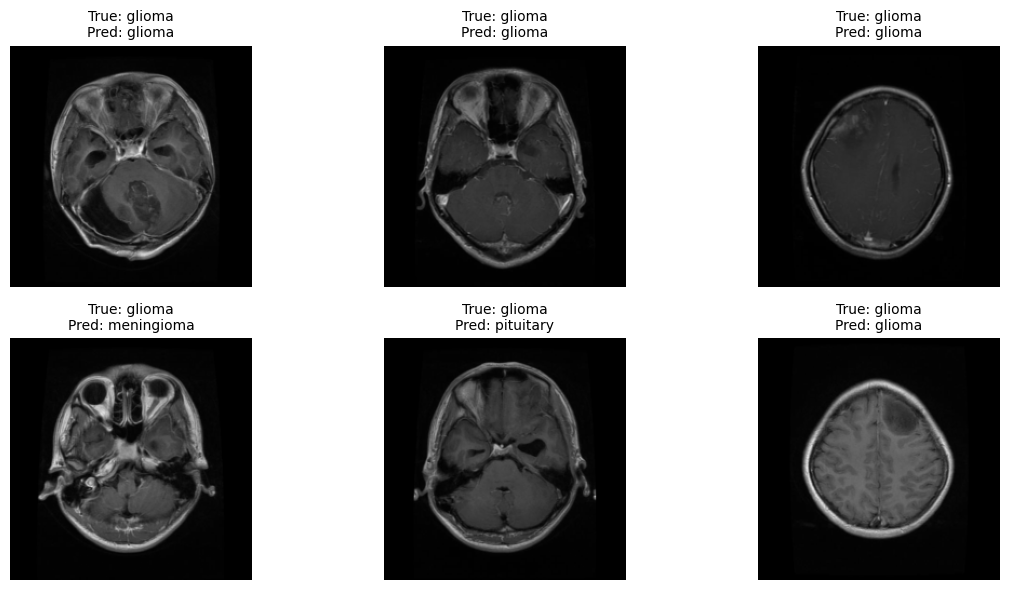

In [14]:
# First test
model2.load_state_dict(torch.load("best_brain_tumor_resnet50.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Initial ResNet50 Model
              precision    recall  f1-score   support

      glioma       0.96      0.82      0.89       300
  meningioma       0.82      0.80      0.81       306
     notumor       0.92      1.00      0.96       405
   pituitary       0.93      0.99      0.96       300

    accuracy                           0.91      1311
   macro avg       0.91      0.90      0.90      1311
weighted avg       0.91      0.91      0.91      1311



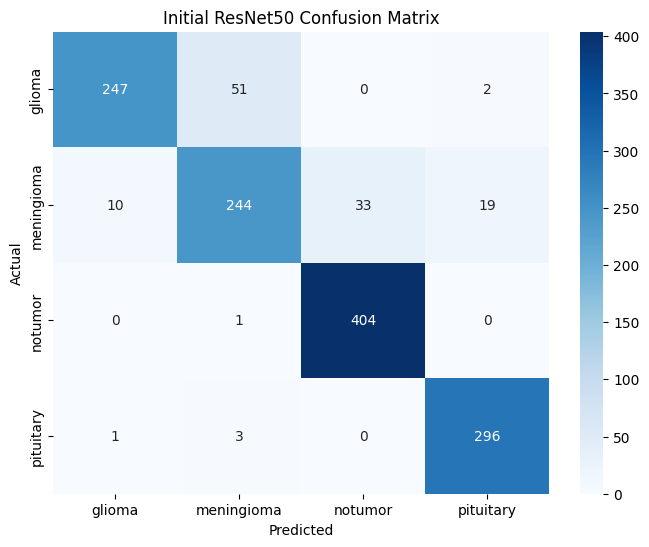

In [15]:
print("\nEvaluation: Initial ResNet50 Model")
model2.load_state_dict(torch.load("best_brain_tumor_resnet50.pth"))
evaluate_model(model2, test_loader, class_names, title="Initial ResNet50 Confusion Matrix")


In [16]:
# Fine-tuning
for name, param in model2.named_parameters():
    if "layer3" in name or "layer4" in name or "fc" in name:
        param.requires_grad = True

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model2.parameters()), lr=1e-4)
history = train_model(model2, train_loader, val_loader, criterion, optimizer, num_epochs=60, name='resnet50_finetuned')

Epoch [1/60] Train Loss: 0.2574, Train Acc: 0.9162 Val Loss: 0.1189, Val Acc: 0.9591
Epoch [2/60] Train Loss: 0.1191, Train Acc: 0.9603 Val Loss: 0.0838, Val Acc: 0.9755
Epoch [3/60] Train Loss: 0.0535, Train Acc: 0.9829 Val Loss: 0.0573, Val Acc: 0.9813
Epoch [4/60] Train Loss: 0.0231, Train Acc: 0.9924 Val Loss: 0.0705, Val Acc: 0.9790
No improvement in validation loss for 1 epoch(s).
Epoch [5/60] Train Loss: 0.0334, Train Acc: 0.9891 Val Loss: 0.0529, Val Acc: 0.9848
Epoch [6/60] Train Loss: 0.0179, Train Acc: 0.9942 Val Loss: 0.1905, Val Acc: 0.9626
No improvement in validation loss for 1 epoch(s).
Epoch [7/60] Train Loss: 0.0285, Train Acc: 0.9901 Val Loss: 0.0446, Val Acc: 0.9860
Epoch [8/60] Train Loss: 0.0407, Train Acc: 0.9905 Val Loss: 0.1790, Val Acc: 0.9661
No improvement in validation loss for 1 epoch(s).
Epoch [9/60] Train Loss: 0.0298, Train Acc: 0.9897 Val Loss: 0.0848, Val Acc: 0.9650
No improvement in validation loss for 2 epoch(s).
Epoch [10/60] Train Loss: 0.0199, T

Test Accuracy: 0.9863


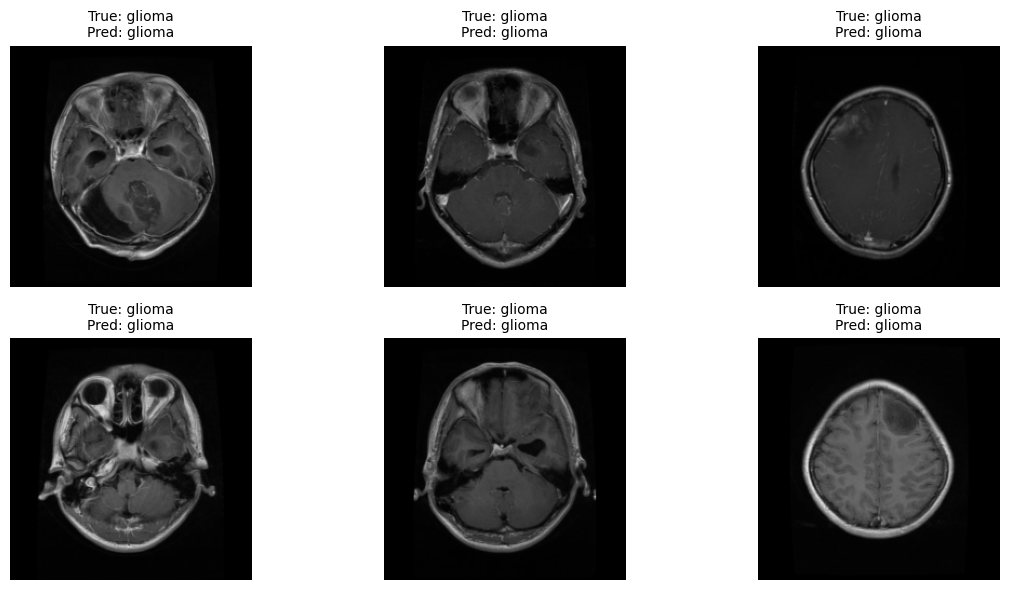

In [17]:
# Final test
model2.load_state_dict(torch.load("best_brain_tumor_resnet50_finetuned.pth"))
test_model(model2, test_loader)
visualize_predictions(model2, test_loader, 6)


Evaluation: Fine-tuned ResNet50 Model
              precision    recall  f1-score   support

      glioma       1.00      0.95      0.97       300
  meningioma       0.96      0.99      0.98       306
     notumor       1.00      1.00      1.00       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



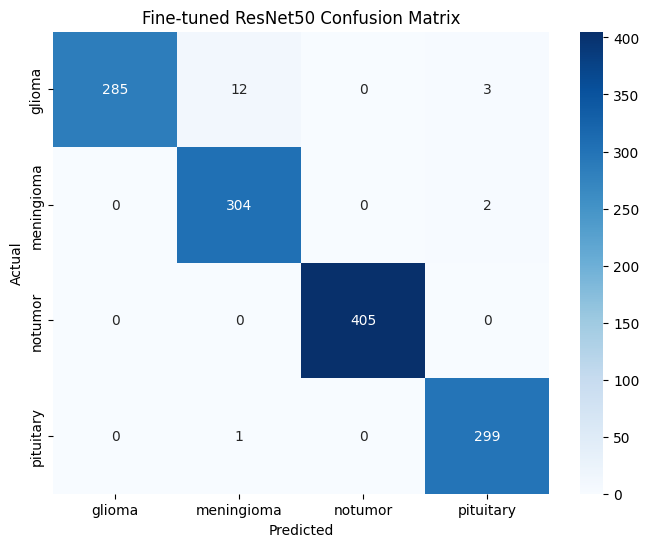

In [18]:
print("\nEvaluation: Fine-tuned ResNet50 Model")
model2.load_state_dict(torch.load("best_brain_tumor_resnet50_finetuned.pth"))
evaluate_model(model2, test_loader, class_names, title="Fine-tuned ResNet50 Confusion Matrix")
